In [ ]:
# this is copied from (22.12)tf_idf_transfer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

In [6]:
xcf_train_df=pd.read_csv('~/final_flavour/appreciation/app_datasets/xcf_ingr_train_df.csv',index_col=0)
ars_train_df=pd.read_csv('~/final_flavour/appreciation/app_datasets/ars_ingr_train_df.csv',index_col=0)
kb_train_df=pd.read_csv('~/final_flavour/appreciation/app_datasets/kb_ingr_train_df.csv',index_col=0)

In [7]:
xcf_test_df=pd.read_csv('~/final_flavour/appreciation/app_datasets/xcf_ingr_test_df.csv',index_col=0)
ars_test_df=pd.read_csv('~/final_flavour/appreciation/app_datasets/ars_ingr_test_df.csv',index_col=0)
kb_test_df=pd.read_csv('~/final_flavour/appreciation/app_datasets/kb_ingr_test_df.csv',index_col=0)

In [10]:
xcf_test_df.head()

,abalone,agar,alfalfa,allspice,almond,amaranth,american_butterfish,angelica,apple,apricot,...,wasabi,water,water_chestnut,welsh_onion,wheat,white_wine,wholewheat_bread,wonton_wrapper,yogurt,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
xcf_train_X=xcf_train_df.drop('class',axis=1)
ars_train_X=ars_train_df.drop('class',axis=1)
kb_train_X=kb_train_df.drop('class',axis=1)

In [12]:
xcf_test_X=xcf_test_df.drop('class',axis=1)
ars_test_X=ars_test_df.drop('class',axis=1)
kb_test_X=kb_test_df.drop('class',axis=1)

In [13]:
xcf_train_y=xcf_train_df['class'].values
ars_train_y=ars_train_df['class'].values
kb_train_y=kb_train_df['class'].values

In [23]:
xcf_test_y=xcf_test_df['class'].values
ars_test_y=ars_test_df['class'].values
kb_test_y=kb_test_df['class'].values

##  Union set of the ingredients

In [14]:
# could only get the ingredients in train set
xcf_ingrs=set(xcf_train_X.columns.tolist())|set(xcf_test_X.columns.tolist())
ars_ingrs=set(ars_train_X.columns.tolist())|set(ars_test_X.columns.tolist())
kb_ingrs=set(kb_train_X.columns.tolist())|set(kb_test_X.columns.tolist())

In [15]:
print(len(xcf_ingrs))
print(len(ars_ingrs))
print(len(kb_ingrs))

251
264
287


In [16]:
allorigin_ingrs=list(xcf_ingrs|ars_ingrs|kb_ingrs )
len(allorigin_ingrs)

404

In [17]:
# xiachufang --> allrecipes, kochbar

In [18]:
def get_origin_target_test_X(allorigin_ingrs,origin_train_X,target_test_X):
    complement_ingrs=list(set(allorigin_ingrs)-set(target_test_X.columns.tolist()))
    complement_tfidf=np.zeros((target_test_X.shape[0],len(complement_ingrs)))
    complement_tfidf=pd.DataFrame(complement_tfidf,columns=complement_ingrs)
    complement_target_test_tfidf=pd.concat([target_test_X,complement_tfidf],axis=1)
    origin_target_test_tfidf=complement_target_test_tfidf[origin_train_X.columns.tolist()]
    return origin_target_test_tfidf

In [19]:
xcf_ars_test_tfidf=get_origin_target_test_X(allorigin_ingrs,xcf_train_X,ars_test_X)
xcf_kb_test_tfidf=get_origin_target_test_X(allorigin_ingrs,xcf_train_X,kb_test_X)

In [20]:
print(xcf_ars_test_tfidf.shape)
print(xcf_kb_test_tfidf.shape)

(640, 251)
(560, 251)


In [21]:
xcf_rf=RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

In [24]:
xcf_rf.fit(xcf_train_X, xcf_train_y)
xcf_pred_y=xcf_rf.predict(xcf_test_X)
print(accuracy_score(xcf_pred_y,xcf_test_y))

0.6746478873239437


In [25]:
xcf_rf.fit(xcf_train_X, xcf_train_y)
xcf_ars_pred_y=xcf_rf.predict(xcf_ars_test_tfidf)
print('xcf-->ars prediction accuracy: ', accuracy_score(xcf_ars_pred_y,ars_test_y))

xcf-->ars prediction accuracy:  0.5203125


In [26]:
xcf_rf.fit(xcf_train_X, xcf_train_y)
xcf_kb_pred_y=xcf_rf.predict(xcf_kb_test_tfidf)
print('xcf-->kb prediction accuracy: ', accuracy_score(xcf_kb_pred_y,kb_test_y))

xcf-->kb prediction accuracy:  0.4607142857142857


In [27]:
# allrecipes --> xiachufang, kochbar

In [28]:
ars_xcf_test_tfidf=get_origin_target_test_X(allorigin_ingrs,ars_train_X,xcf_test_X)
ars_kb_test_tfidf=get_origin_target_test_X(allorigin_ingrs,ars_train_X,kb_test_X)

In [29]:
ars_log=LogisticRegression(C=1, random_state=9527)

In [30]:
ars_log.fit(ars_train_X, ars_train_y)
ars_pred_y=ars_log.predict(ars_test_X)
print(accuracy_score(ars_pred_y,ars_test_y))

0.696875


In [31]:
ars_log.fit(ars_train_X,ars_train_y)
ars_xcf_pred_y=ars_log.predict(ars_xcf_test_tfidf)
print('ars-->xcf prediction accuracy: ', accuracy_score(ars_xcf_pred_y,xcf_test_y))

ars-->xcf prediction accuracy:  0.5225352112676056


In [32]:
ars_log.fit(ars_train_X, ars_train_y)
ars_kb_pred_y=ars_log.predict(ars_kb_test_tfidf)
print('ars-->kb prediction accuracy: ', accuracy_score(ars_kb_pred_y,kb_test_y))

ars-->kb prediction accuracy:  0.45714285714285713


In [33]:
# kochbar --> xiachufang, allrecipes

In [34]:
kb_xcf_test_tfidf=get_origin_target_test_X(allorigin_ingrs,kb_train_X,xcf_test_X)
kb_ars_test_tfidf=get_origin_target_test_X(allorigin_ingrs,kb_train_X,ars_test_X)

In [35]:
kb_log=LogisticRegression(C=0.1, random_state=9527)

In [36]:
kb_log.fit(kb_train_X, kb_train_y)
kb_pred_y=kb_log.predict(kb_test_X)
print(accuracy_score(kb_pred_y,kb_test_y))

0.625


In [37]:
kb_log.fit(kb_train_X, kb_train_y)
kb_xcf_pred_y=kb_log.predict(kb_xcf_test_tfidf)
print('kb-->xcf prediction accuracy: ', accuracy_score(kb_xcf_pred_y,xcf_test_y))

kb-->xcf prediction accuracy:  0.43802816901408453


In [38]:
kb_log.fit(kb_train_X, kb_train_y)
kb_ars_pred_y=kb_log.predict(kb_ars_test_tfidf)
print('kb-->ars prediction accuracy: ', accuracy_score(kb_ars_pred_y,ars_test_y))

kb-->ars prediction accuracy:  0.48125


In [ ]:
# visualization

In [57]:
accu_dict={'Xiachufang':[0.67,0.52,0.46],
           'Allrecipes':[0.52,0.70,0.46],
           'Kochbar':[0.44,0.48,0.63]}

In [58]:
accu_df=pd.DataFrame(accu_dict)

In [59]:
accu_df.index=['Xiachufang','Allrecipes','Kochbar']

In [65]:
accu_df

,Xiachufang,Allrecipes,Kochbar
Xiachufang,0.67,0.52,0.44
Allrecipes,0.52,0.70,0.48
Kochbar,0.46,0.46,0.63


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

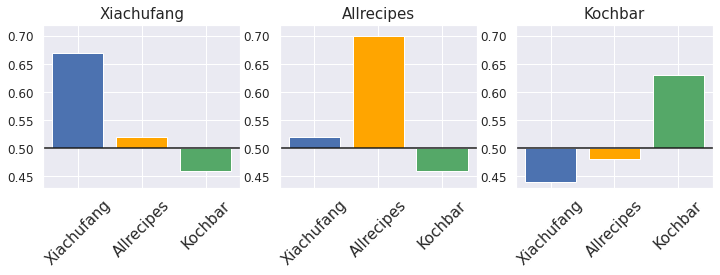

In [69]:
sns.set()
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
baseline=0.5
plt.bar([0,1,2],accu_df.Xiachufang-0.5,bottom=baseline,color=['b','orange','g'])
plt.xticks([0,1,2],accu_df.index,fontsize=15,rotation=45)
plt.yticks(fontsize=12)
plt.axhline(0.5,color='k') # 将baseline标注出来
plt.ylim(0.43,0.72)
plt.title('Xiachufang',fontsize=15)

plt.subplot(1,3,2)
baseline=0.5
plt.bar([0,1,2],accu_df.Allrecipes-0.5,bottom=baseline,color=['b','orange','g'])
plt.xticks([0,1,2],accu_df.index,fontsize=15,rotation=45)
plt.yticks(fontsize=12)
plt.axhline(0.5,color='k') # 将baseline标注出来
plt.ylim(0.43,0.72)
plt.title('Allrecipes',fontsize=15)

plt.subplot(1,3,3)
baseline=0.5
plt.bar([0,1,2],accu_df.Kochbar-0.5,bottom=baseline,color=['b','orange','g'])
plt.xticks([0,1,2],accu_df.index,fontsize=15,rotation=45)
plt.yticks(fontsize=12)
plt.axhline(0.5,color='k') # 将baseline标注出来
plt.ylim(0.43,0.72)
plt.title('Kochbar',fontsize=15)

plt.savefig('fig/pdf/ingr_tfidf_ingr_cross_model.pdf',dpi=300,bbox_inches='tight')
plt.savefig('fig/png/ingr_tfidf_ingr_cross_model.png',dpi=300,bbox_inches='tight')